In [5]:
# predict

from neurotron import Cluster, Token, Record, Monitor, isa
import neurotron.math as nm


In [15]:
class Cells(Cluster):
    def __init__(self,shape,token=None):
        nm.seed(1)
        cells = super().__init__(*shape,verbose=1)
        self.token = token
        m,n,d,s = shape
        f = [0,0,0] if token is None else token['.']
        self.y = nm.row(nm.zeros(1,m*n),f)
        self.record = Record(self)

    def process(self,seq):
        m,n,d,s = self.shape
        seq = [seq] if isa(seq,str) else seq
        prediction = [seq[0],'->']
        for word in seq:
            mon = Monitor(m,n);
            self.y = nm.row(nm.zeros(1,m*n),token[word])
            self.y = self.step(mon,self.y,word)
            output,predict = self.decode()
            mon.xlabel((n-1)/2,output+' -> '+predict)
            prediction.append(predict)
        return prediction

    def predictive(self,list):
        for k in list:
            cells.X[k] = 1;
            cells._predict.I[k] = Matrix([[.1,-.1,.1,-.1,.1],[0,0,0,0,0]])

    def __str__(self):
        self.record.clear();  
        self.record(self)
        return self.record.pattern()

    def __repr__(self):
        return self.__str__()



In [16]:
#=========================================================================
# setup network
#=========================================================================

token = Token({'Mary': [1,0,0,0,0,0,0,1,1],
               'John': [0,1,0,0,0,0,0,1,1],
               'Lisa': [1,0,0,0,0,0,1,1,0],
               'Andy': [0,1,0,0,0,0,1,1,0],
               'likes':[0,0,1,0,0,0,0,1,1],
               'to':   [0,0,0,1,0,0,0,1,1],
               'sing': [0,0,0,0,1,0,0,1,1],
               'dance':[0,0,0,0,0,1,0,1,1],
               'hike': [0,0,0,0,1,0,1,1,0],
               'climb':[0,0,0,0,1,0,1,0,1],
               '.':    [0,0,0,0,0,0,1,1,1],
              })
    
def setup(token):
    shape = (2,9,8,3);  
    cells = Cells(shape,token)
    cells._predict.clear()

    try:
        cells.connect([0,14,16],[4,14,16])  # Mary -> likes
        cells.connect([4,14,16],[6,14,16])  # likes -> to
        cells.connect([6,14,16],[8,14,16])  # to -> sing
        cells.connect([8,14,16],[12,14,16]) # sing -> .

        cells.connect([2,14,16],[5,15,17])  # John -> likes  
        cells.connect([5,15,17],[7,15,17])  # likes -> to
        cells.connect([7,15,17],[10,15,17]) # to(7,15,17) -> dance(10,15,17)
        cells.connect([10,15,17],[13,15,17])# dance -> .

        cells.connect([0,12,14],[4,14,17])  # Lisa -> likes
        cells.connect([4,14,17],[6,15,16])  # likes -> to
        cells.connect([6,15,16],[8,12,14])  # to -> hike
        cells.connect([8,12,14],[13,15,17]) # hike -> .

        cells.connect([2,12,14],[5,14,17])  # Andy -> likes
        cells.connect([5,14,17],[7,15,16])  # likes -> to
        cells.connect([7,15,16],[9,12,16])  # to -> climb
        cells.connect([9,12,16],[13,15,17]) # climb -> .
    except Synapse as s:
        print(Ansi.R,'*** warning:',str(s),Ansi.N)
        
    return cells

cells = setup(token)


learn P[14].1: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[16].1: [0.6 0.6 0.6] by [0.1 0.1 0.1]
mind I[4].0: [0.1 0.1 0.1]
mind I[14].0: [0.1 0.1 0.1]
mind I[16].0: [0.1 0.1 0.1]
learn P[4].0: [0.7 0.7 0.7] by [0.1 0.1 0.1]
learn P[14].0: [0.7 0.7 0.7] by [0.1 0.1 0.1]
learn P[16].0: [0.7 0.7 0.7] by [0.1 0.1 0.1]
mind I[6].0: [0.1 0.1 0.1]
mind I[14].1: [0.1 0.1 0.1]
mind I[16].1: [0.1 0.1 0.1]
learn P[6].0: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[14].1: [0.7 0.7 0.7] by [0.1 0.1 0.1]
learn P[16].1: [0.7 0.7 0.7] by [0.1 0.1 0.1]
mind I[8].0: [0.1 0.1 0.1]
mind I[14].2: [0.1 0.1 0.1]
mind I[16].2: [0.1 0.1 0.1]
learn P[8].0: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[14].2: [0.6 0.6 0.6] by [0.1 0.1 0.1]
learn P[16].2: [0.6 0.6 0.6] by [0.1 0.1 0.1]
mind I[12].0: [0.1 0.1 0.1]
mind I[14].3: [0.1 0.1 0.1]
mind I[16].3: [0.1 0.1 0.1]


['Mary', '->', 'likes', 'to', 'sing', '.']

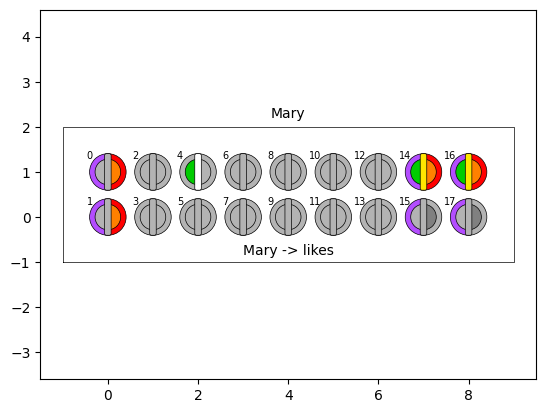

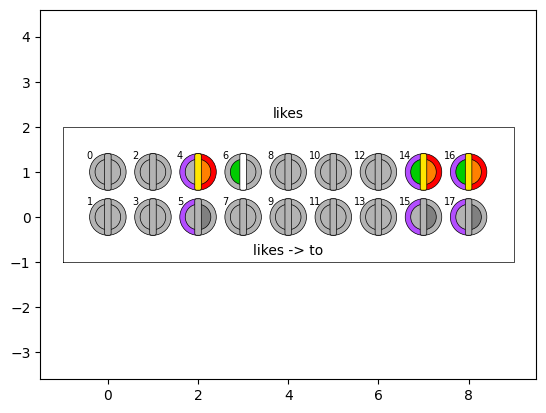

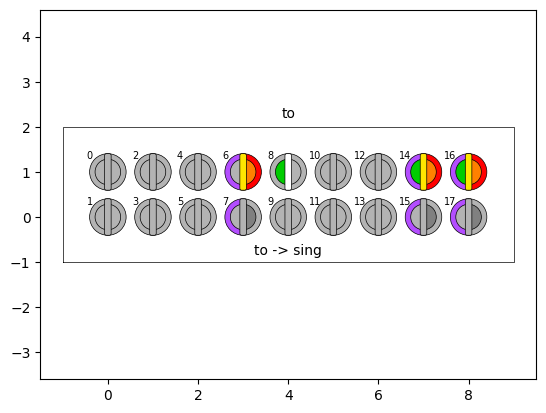

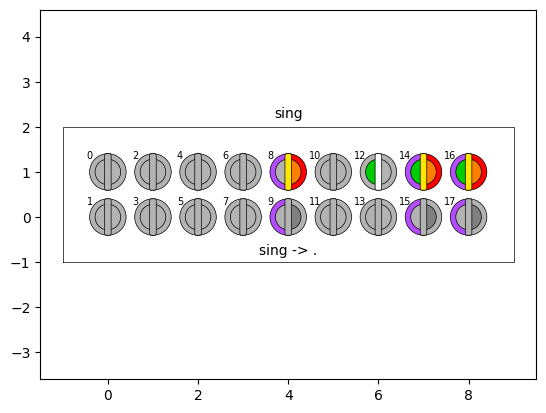

In [19]:
cells.process(['Mary','likes','to','sing'])